<a href="https://colab.research.google.com/github/llev25/colab/blob/main/Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy import linalg

class Camera(object):
  def __init__(self, P):
    self.P = P
    self.K = None # калибровочная матрица
    self.R = None # поворо
    self.t = None # перенос
    self.c = None # центр камеры

  def project(self, X):
    x = dot(self.P, X)
    for i in range(3):
      x[i] /= x[2]
    return x

In [ ]:
def calibration(sz):
  row, col = sz
  fx = 100,1 * col / 960
  fy = 36,4 * row / 720
  K = diag([fx, fy, 1])
  K[0,2] = 0.5 * col
  K[1,2] = 0.5 * row
  return K

In [ ]:
!pip uninstall imgaug
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python

!pip install imgaug==0.2.5
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.6/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 563kB 2.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-cp36-none-any.whl size=561440 sha256=352a473316fad1577b016bea657d57bb8778005d8bb3a98e37f92bdd28577f19
  Stored in directory: /root/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae

In [ ]:
import cv2
print(cv2.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

# read images

img1 = cv2.imread('/content/drive/My Drive/Calibration /heetsFront.jpg')  
img2 = cv2.imread('/content/drive/My Drive/Calibration /heetsDeg.jpg') 


sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

# выбор лучших(нужно проработать)
numGoodMatches = int(len(matches) * 0.15)
matches = matches[:numGoodMatches]

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches, img2, flags=2)


3.4.2


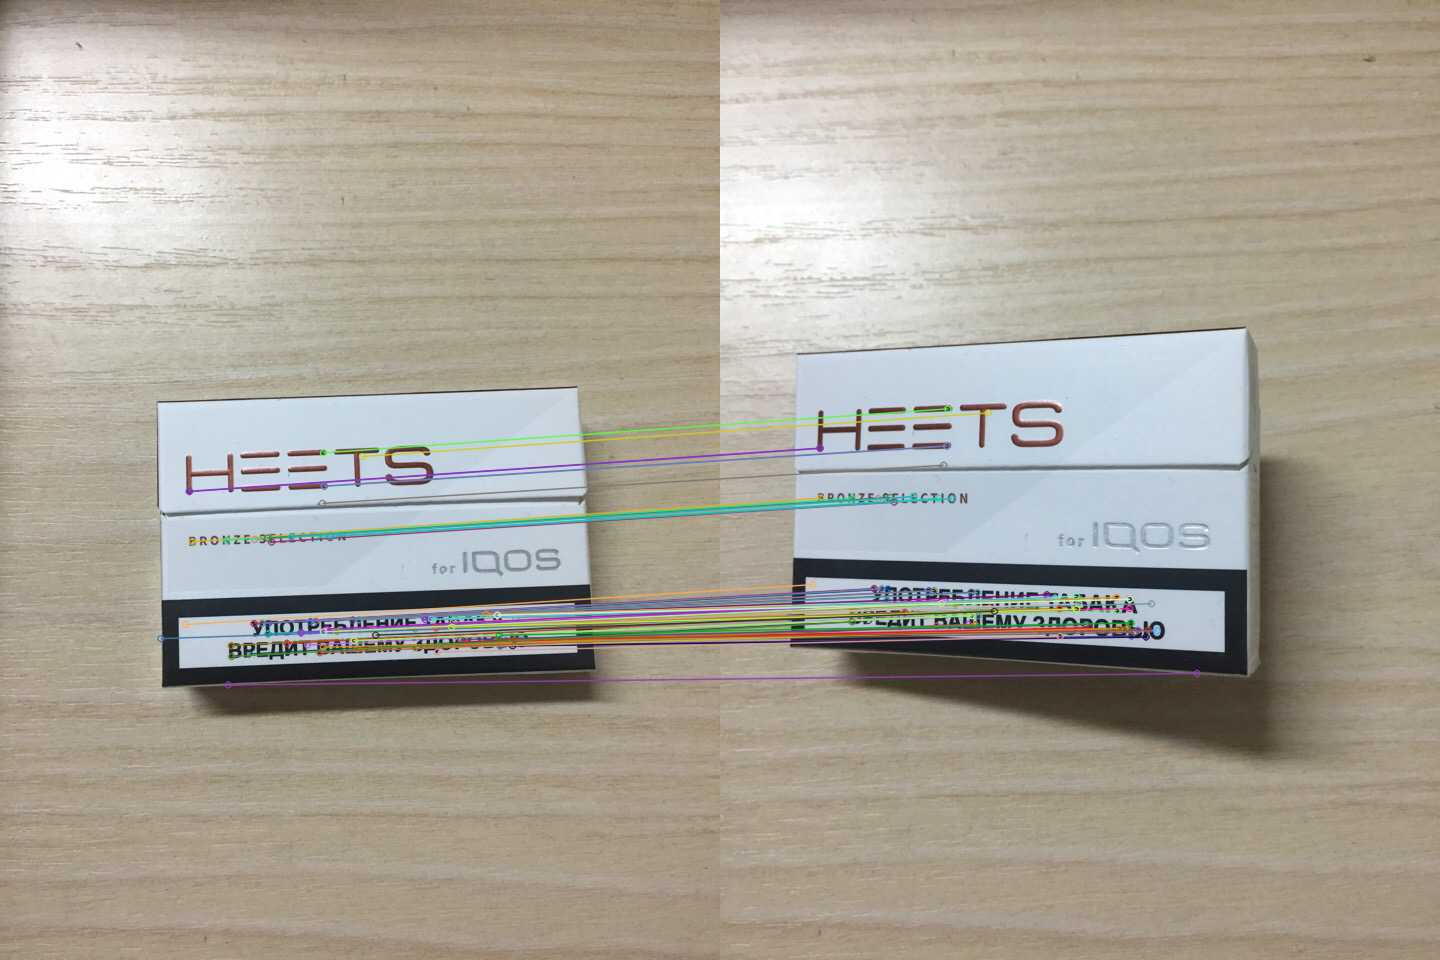

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(img3)

In [ ]:
import numpy as np

# Extract location of matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
  points1[i, :] = keypoints_1[match.queryIdx].pt
  points2[i, :] = keypoints_2[match.trainIdx].pt
  
# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

In [ ]:
height, width, t = img2.shape
imReg = cv2.warpPerspective(img1, h, (width, height))

print("Estimated homography : \n",  h)

Estimated homography : 
 [[ 8.15276530e-01 -2.48749347e-02 -4.76161862e+01]
 [-1.62305354e-01  1.02664752e+00 -5.00173420e+01]
 [-3.95573464e-04  5.28796762e-05  1.00000000e+00]]


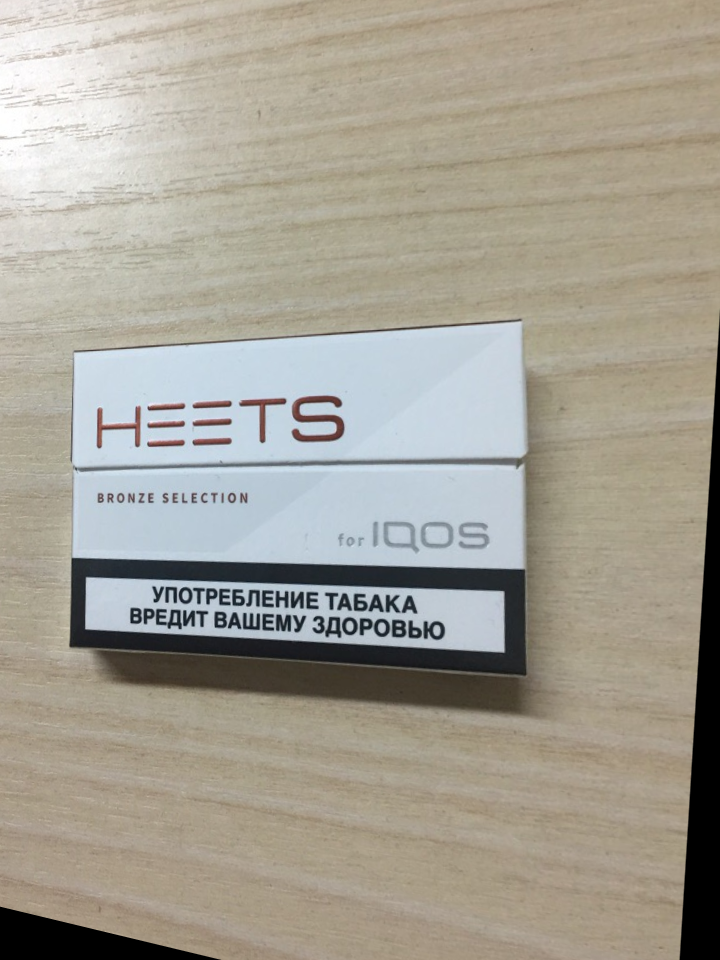

In [ ]:
cv2_imshow(imReg)

In [ ]:
def homoPoint(x,y):
  point = np.array([x,y,1], np.int32) 
  point = point.reshape(3, 1)
  point = np.dot(h, point)
  point /= point[2]
  return point

[[-47.61618624 -50.01734201]]
69.05820511054613
(960, 720, 3)
[[[325.47089744 445.47089744]
  [325.47089744 514.47089744]
  [394.47089744 514.47089744]
  [394.47089744 445.47089744]]]
(1, 4, 2)


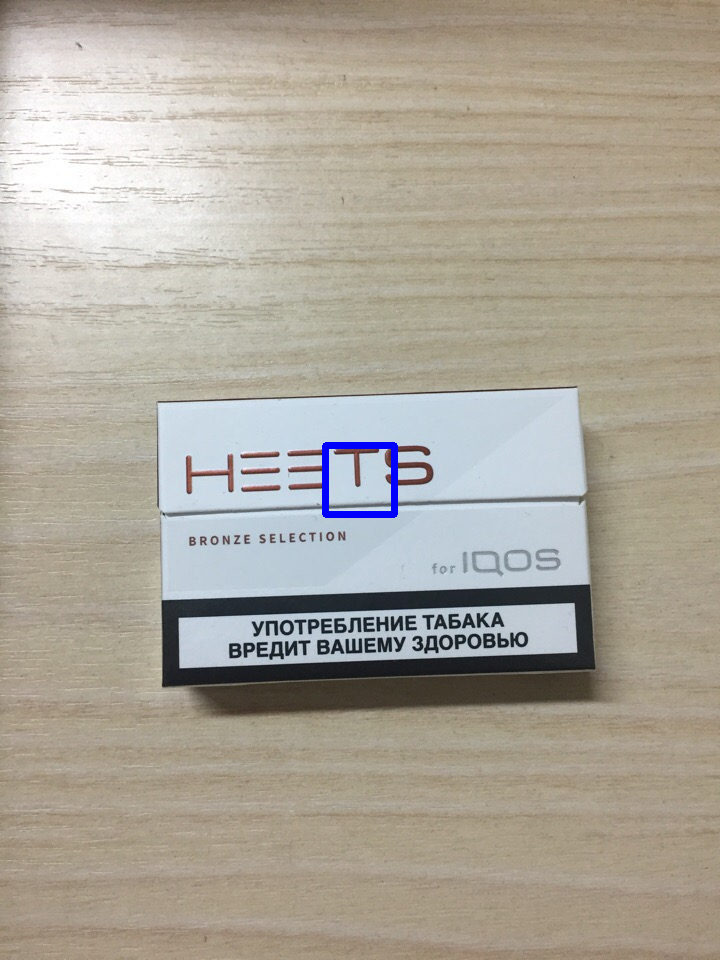

In [ ]:
import math


transPoint = homoPoint(0,0)[:2].reshape(1,2)
print(transPoint)

a = math.hypot(0 - transPoint[0,1], 0 - transPoint[0,0])
print(a)

pts = np.array([[0, 0], [0, a], [a, a],  
                [a, 0]], 
               np.int32) 

print(img1.shape)
x, y =  pts.shape
j, k, c = img1.shape
pts = pts + [k/2,j/2] - a/2
pts = pts.reshape(-1, x, y)


image = img1.copy()
image = cv2.polylines(image, np.int32(pts), True, (255, 0, 0), 5) 
print(pts)
print(pts.shape)



cv2_imshow(image)

In [ ]:
quadBase = np.concatenate((homoPoint(pts[0,0,0],pts[0,0,1])[:2],
                           homoPoint(pts[0,1,0],pts[0,1,1])[:2],
                           homoPoint(pts[0,2,0],pts[0,2,1])[:2],
                           homoPoint(pts[0,3,0],pts[0,3,1])[:2]))
y = 4
x = 2

quadBase = quadBase.reshape(y, x)
props = np.zeros((y*2, x))
quadTop = np.zeros((y, x))


for i in range(y):
  props[i*2] = quadBase[i]
  props[i*2+1] = quadBase[i] + transPoint

for i in range(y):
  quadTop[i] = props[i*2 + 1]

print('\n Base:')
print(math.hypot(quadBase[0,1] - quadBase[1,1], quadBase[0,0] - quadBase[1,0]))
print(math.hypot(quadBase[0,1] - quadBase[3,1], quadBase[0,0] - quadBase[3,0]))
print(math.hypot(quadBase[2,1] - quadBase[1,1], quadBase[2,0] - quadBase[1,0]))
print(math.hypot(quadBase[2,1] - quadBase[3,1], quadBase[2,0] - quadBase[3,0]))

print('\n Props:')
print(math.hypot(props[0,1] - props[1,1], props[0,0] - props[1,0]))
print(math.hypot(props[2,1] - props[3,1], props[2,0] - props[3,0]))
print(math.hypot(props[4,1] - props[5,1], props[4,0] - props[5,0]))
print(math.hypot(props[6,1] - props[7,1], props[6,0] - props[7,0]))

print('\n Top:')
print(math.hypot(quadTop[0,1] - quadTop[1,1], quadTop[0,0] - quadTop[1,0]))
print(math.hypot(quadTop[0,1] - quadTop[3,1], quadTop[0,0] - quadTop[3,0]))
print(math.hypot(quadTop[2,1] - quadTop[1,1], quadTop[2,0] - quadTop[1,0]))
print(math.hypot(quadTop[2,1] - quadTop[3,1], quadTop[2,0] - quadTop[3,0]))

print('\n Degrees:')

print('A: ', math.degrees(math.atan2(quadTop[0,1] - quadTop[1,1], quadTop[0,0] - quadTop[1,0])))
print('B: ',90 + math.degrees(math.atan2(quadTop[3,1] - quadTop[0,1], quadTop[3,0] - quadTop[0,0])))
print('C: ',math.degrees(math.atan2(quadTop[2,1] - quadTop[3,1], quadTop[2,0] - quadTop[3,0])))
print('D: ',90 + math.degrees(math.atan2(quadTop[2,1] - quadTop[1,1], quadTop[2,0] - quadTop[1,0])))



 Base:
77.27658596506878
72.08502943228096
71.71933967437292
79.71092133373524

 Props:
69.05820511054614
69.05820511054614
69.05820511054614
69.05820511054614

 Top:
77.27658596506878
72.08502943228096
71.71933967437292
79.71092133373524

 Degrees:
A:  -87.88948959807169
B:  89.63350767686993
C:  92.32728233182586
D:  91.56595251534849


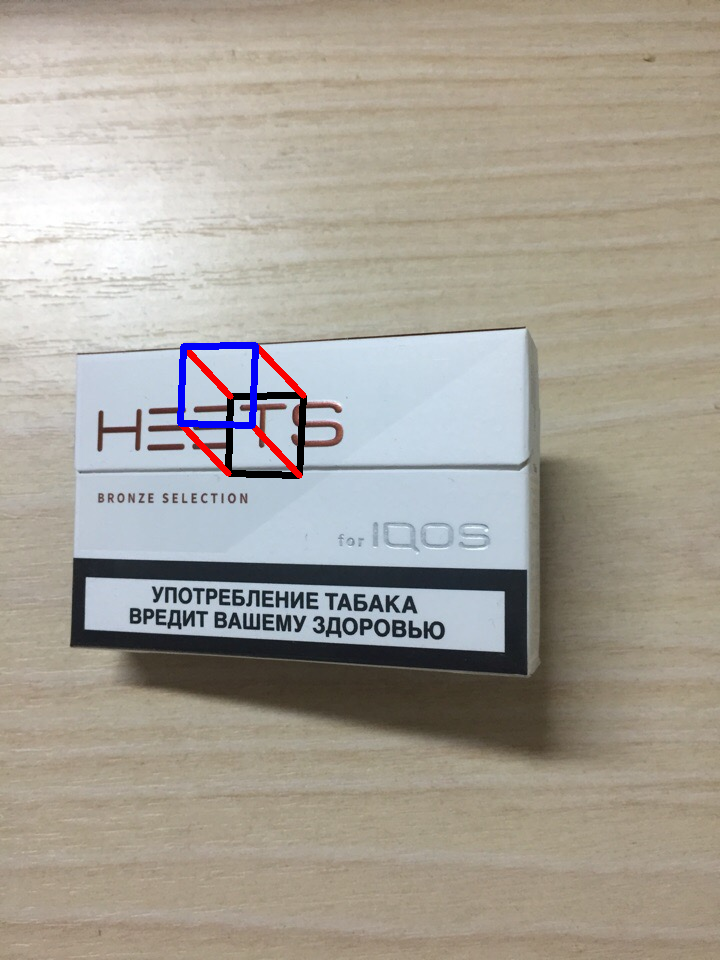

In [ ]:
img2C = img2.copy()

quadBase = quadBase.reshape(1, y, x)
props = props.reshape(1, y*2, x)
quadTop = quadTop.reshape(1, y, x)

cv2.polylines(img2C, np.int32(quadBase.round()), True, (0, 0, 0), 5) 

propsInt = np.int32(props.round())

for i in range(4):
  cv2.polylines(img2C, propsInt[:,(i*2):(i*2+2)], True, (0, 0, 250), 5) 

cv2.polylines(img2C, np.int32(quadTop.round()), True, (250, 0, 0), 5) 

cv2_imshow(img2C)

Text(0.5, 0, 'Z')

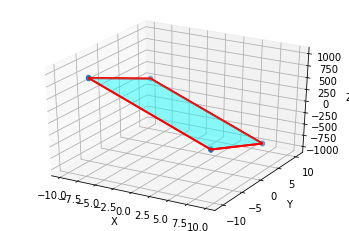

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

points = np.array([[-1, -1, -1],
                     [1, -1, -1 ],
                     [1, 1, -1],
                     [-1, 1, -1],
                     [-1, -1, 1],
                     [1, -1, 1 ],
                     [1, 1, 1],
                     [-1, 1, 1]])


Z = np.zeros((8,3))
for i in range(8): Z[i,:] = np.dot(points[i,:],h)
Z = 10.0*Z

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

r = [-1,1]

X, Y = np.meshgrid(r, r)
# plot vertices
ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

# list of sides' polygons of figure
verts = [[Z[0],Z[1],Z[2],Z[3]],
    [Z[4],Z[5],Z[6],Z[7]], 
    [Z[0],Z[1],Z[5],Z[4]], 
    [Z[2],Z[3],Z[7],Z[6]], 
    [Z[1],Z[2],Z[6],Z[5]],
    [Z[4],Z[7],Z[3],Z[0]], 
    [Z[2],Z[3],Z[7],Z[6]]]

# plot sides
ax.add_collection3d(Poly3DCollection(verts, 
    facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#plt.show()
